In [1]:
%config InlineBackend.figure_formats = ['svg']
import os

STATIC_WEB_PAGE = {"EXECUTE_NB", "READTHEDOCS"}.intersection(os.environ)

```{autolink-concat}
```

# Riemann sheets for two channels

In [2]:
%pip install -q ampform==0.14.6 plotly==5.17.0 sympy==1.12

Note: you may need to restart the kernel to use updated packages.


In [3]:
from __future__ import annotations

import warnings

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import sympy as sp
from ampform.io import aslatex
from ampform.sympy import UnevaluatedExpression, implement_doit_method
from ampform.sympy.math import create_expression
from IPython.display import Math

warnings.filterwarnings("ignore")

## Squareroot definition 
See report on Riemann sheets for one channel case [Link]

In [4]:
@implement_doit_method
class SignedSqrt(UnevaluatedExpression):
    is_commutative = True
    is_real = False

    def __new__(cls, z, **hints) -> SignedSqrt:
        return create_expression(cls, z, **hints)

    def evaluate(self) -> sp.Expr:
        z = self.args[0]
        return sp.sqrt(abs(z)) * sp.exp(sp.I * PosArg(z) / 2)

    def _latex(self, printer, *args) -> str:
        z = printer._print(self.args[0])
        return Rf"\sqrt[+]{{{z}}}"


@implement_doit_method
class PosArg(UnevaluatedExpression):
    is_commutative = True

    def __new__(cls, z, **hints) -> SignedSqrt:
        return create_expression(cls, z, **hints)

    def evaluate(self) -> sp.Expr:
        z = self.args[0]
        arg = sp.arg(z)
        return sp.Piecewise(
            (arg + 2 * sp.pi, arg < -2 * sp.pi),
            (arg - 2 * sp.pi, arg > 0),
            (arg, True),
        )

    def _latex(self, printer, *args) -> str:
        z = printer._print(self.args[0])
        return Rf"\arg^+\left({z}\right)"


z = sp.Symbol("z", complex=True)
Math(aslatex({e: e.evaluate() for e in [SignedSqrt(z), PosArg(z)]}))

<IPython.core.display.Math object>

In [5]:
@implement_doit_method
class PhaseSpaceFactor(UnevaluatedExpression):
    is_commutative = True
    is_real = False

    def __new__(cls, s, m1, m2, **hints) -> PhspFactor:
        return create_expression(cls, s, m1, m2, *hints)

    def evaluate(self) -> sp.Expr:
        s, m1, m2 = self.args
        return SignedSqrt((s - ((m1 + m2) ** 2)) * (s - (m1 - m2) ** 2) / s**2)

    def _latex(self, printer: LatexPrinter, *args) -> str:
        s = printer._print(self.args[0])
        return Rf"\rho^+\left({s}\right)"
        return Rf"\rho^+\left({s}\right)"
        return Rf"\rho^+\left({s}\right)"
        return Rf"\rho^+\left({s}\right)"
        return Rf"\rho^+\left({s}\right)"


s, m_a, m_b = sp.symbols("s m_a m_b")
rho_expr = PhaseSpaceFactor(s, m_a, m_b)
Math(aslatex({rho_expr: rho_expr.doit(deep=False)}))

<IPython.core.display.Math object>

In [6]:
@implement_doit_method
class BreakupMomentum(UnevaluatedExpression):
    is_commutative = True
    is_real = False

    def __new__(cls, s, m_a, m_b, **hints) -> PhspFactor:
        return create_expression(cls, s, m_a, m_b, **hints)

    def evaluate(self) -> sp.Expr:
        s, m_a, m_b = self.args
        return SignedSqrt((s - (m_a + m_b) ** 2) * (s - (m_a - m_b) ** 2) / (s * 4))

    def _latex(self, printer: LatexPrinter, *args) -> str:
        s = printer._print(self.args[0])
        return Rf"q^+\left({s}\right)"


breakup_momentum = BreakupMomentum(s, m_a, m_b)
Math(aslatex({breakup_momentum: breakup_momentum.doit(deep=False)}))

<IPython.core.display.Math object>

In [7]:
@implement_doit_method
class ChewMandelstamm(UnevaluatedExpression):
    is_commutative = True
    is_real = False

    def __new__(cls, s, m1, m2, **hints) -> PhspFactor:
        return create_expression(cls, s, m1, m2, *hints)

    def evaluate(self) -> sp.Expr:
        s, m1, m2 = self.args
        q_break = BreakupMomentum(s, m1, m2)
        return (
            1
            / (16 * (sp.pi) ** 2)
            * (
                (2 * q_break / sp.sqrt(s))
                * sp.log(
                    (m1**2 + m2**2 - s + 2 * sp.sqrt(s) * q_break) / (2 * m1 * m2)
                )
                - (m1**2 - m2**2) * (1 / s - 1 / (m1 + m2) ** 2) * sp.log(m1 / m2)
            )
        )

    def _latex(self, printer: LatexPrinter, *args) -> str:
        s = printer._print(self.args[0])
        m1 = printer._print(self.args[1])
        m2 = printer._print(self.args[2])
        return Rf"\rho^\text{{CM}}\left({s},{m1},{m2}\right)"


cm_expr = ChewMandelstamm(s, m_a, m_b)
Math(aslatex({cm_expr: cm_expr.doit(deep=False)}))

<IPython.core.display.Math object>

### Visual comparison

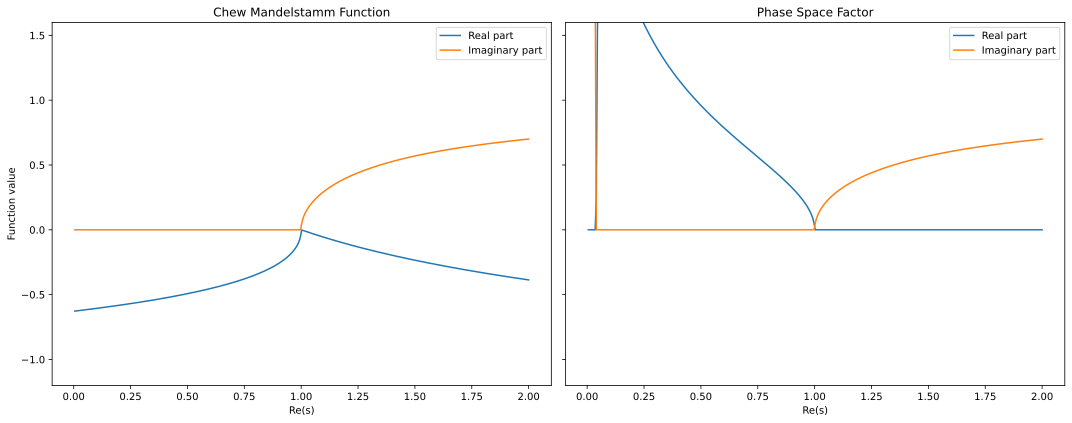

In [8]:
args = (s, m_a, m_b)
cm_func_sym = sp.lambdify(args, cm_expr.doit())
rho_func = sp.lambdify(args, rho_expr.doit())

s_values = np.linspace(0, 2, 400)
m1_val = 0.6
m2_val = 0.4
arg_vals = (m1_val, m2_val)

cm_values = 16 * np.pi * cm_func_sym(s_values, *arg_vals)
rho_values = 1j * rho_func(s_values, *arg_vals)

fig, axes = plt.subplots(figsize=(15, 6), ncols=2, sharex=True, sharey=True)
ax1, ax2 = axes
ax1.plot(s_values, cm_values.real, label="Real part")
ax1.plot(s_values, cm_values.imag, label="Imaginary part")
ax1.set_xlabel("Re(s)")
ax1.set_ylabel("Function value")
ax1.set_title("Chew Mandelstamm Function")
ax1.legend()

ax2.plot(s_values, rho_values.real, label="Real part")
ax2.plot(s_values, rho_values.imag, label="Imaginary part")
ax2.set_xlabel("Re(s)")
ax2.set_title("Phase Space Factor")
ax2.legend()


ax2.set_ylim(-1.2, +1.6)
plt.tight_layout()

plt.show()

## Define parameters values for plotting 

## T matrix definition with K matrix

In [9]:
n_channels = 2
I = sp.Identity(n_channels)
K = sp.MatrixSymbol("K", n_channels, n_channels)
rho_symbol = sp.MatrixSymbol("rho", n_channels, n_channels)
rho = sp.DiagonalMatrix(rho_symbol)
rho.as_explicit()

Matrix([
[rho[0, 0],         0],
[        0, rho[1, 1]]])

In [30]:
T = (I - K * rho).inv() * K
T

(I - K*DiagonalMatrix(rho))**(-1)*K

In [31]:
T_explicit = T.as_explicit()
T_explicit

Matrix([
[(-K[1, 1]*rho[1, 1] + 1)*K[0, 0]/(K[0, 0]*K[1, 1]*rho[0, 0]*rho[1, 1] - K[0, 0]*rho[0, 0] - K[0, 1]*K[1, 0]*rho[0, 0]*rho[1, 1] - K[1, 1]*rho[1, 1] + 1) + K[0, 1]*K[1, 0]*rho[1, 1]/(K[0, 0]*K[1, 1]*rho[0, 0]*rho[1, 1] - K[0, 0]*rho[0, 0] - K[0, 1]*K[1, 0]*rho[0, 0]*rho[1, 1] - K[1, 1]*rho[1, 1] + 1), (-K[1, 1]*rho[1, 1] + 1)*K[0, 1]/(K[0, 0]*K[1, 1]*rho[0, 0]*rho[1, 1] - K[0, 0]*rho[0, 0] - K[0, 1]*K[1, 0]*rho[0, 0]*rho[1, 1] - K[1, 1]*rho[1, 1] + 1) + K[0, 1]*K[1, 1]*rho[1, 1]/(K[0, 0]*K[1, 1]*rho[0, 0]*rho[1, 1] - K[0, 0]*rho[0, 0] - K[0, 1]*K[1, 0]*rho[0, 0]*rho[1, 1] - K[1, 1]*rho[1, 1] + 1)],
[(-K[0, 0]*rho[0, 0] + 1)*K[1, 0]/(K[0, 0]*K[1, 1]*rho[0, 0]*rho[1, 1] - K[0, 0]*rho[0, 0] - K[0, 1]*K[1, 0]*rho[0, 0]*rho[1, 1] - K[1, 1]*rho[1, 1] + 1) + K[0, 0]*K[1, 0]*rho[0, 0]/(K[0, 0]*K[1, 1]*rho[0, 0]*rho[1, 1] - K[0, 0]*rho[0, 0] - K[0, 1]*K[1, 0]*rho[0, 0]*rho[1, 1] - K[1, 1]*rho[1, 1] + 1), (-K[0, 0]*rho[0, 0] + 1)*K[1, 1]/(K[0, 0]*K[1, 1]*rho[0, 0]*rho[1, 1] - K[0, 0]*rh

No Blatt-Weisskopf-Formfactors because $L=0$:

In [32]:
s = sp.Symbol("s")
m_a_1 = sp.Symbol(R"m_{a,1}")
m_b_1 = sp.Symbol(R"m_{b,1}")
m_a_2 = sp.Symbol(R"m_{a,2}")
m_b_2 = sp.Symbol(R"m_{b,2}")
w_R = sp.Symbol(R"\Gamma_{R}")
gamma_R_1 = sp.Symbol(R"\gamma_{R,1}")
gamma_R_2 = sp.Symbol(R"\gamma_{R,2}")
m_R = sp.Symbol(R"m_R")

k_expr_00 = (gamma_R_1 * gamma_R_1 * m_R * w_R) / (s - m_R**2)
k_expr_10 = (gamma_R_1 * gamma_R_2 * m_R * w_R) / (s - m_R**2)
k_expr_11 = (gamma_R_2 * gamma_R_2 * m_R * w_R) / (s - m_R**2)

In [33]:
rho_expressions = {
    K[0, 0]: k_expr_00,
    K[1, 1]: k_expr_11,
    K[0, 1]: k_expr_10,
    K[1, 0]: k_expr_10,
    rho[0, 0]: PhaseSpaceFactor(s, m_a_1, m_b_1),
    rho[1, 1]: PhaseSpaceFactor(s, m_a_2, m_b_2),
}
Math(aslatex(rho_expressions))

<IPython.core.display.Math object>

In [34]:
cm_expressions = {
    K[0, 0]: k_expr_00,
    K[1, 1]: k_expr_11,
    K[0, 1]: k_expr_10,
    K[1, 0]: k_expr_10,
    rho[0, 0]: -sp.I * 16 * sp.pi * ChewMandelstamm(s, m_a_1, m_b_1),
    rho[1, 1]: -sp.I * 16 * sp.pi * ChewMandelstamm(s, m_a_2, m_b_2),
}
Math(aslatex(cm_expressions))

<IPython.core.display.Math object>

In [35]:
cm_conj_expressions = {
    K[0, 0]: k_expr_00,
    K[1, 1]: k_expr_11,
    K[0, 1]: k_expr_10,
    K[1, 0]: k_expr_10,
    rho[0, 0]: -sp.I * 16 * sp.pi * ChewMandelstamm(s, m_a_1, m_b_1).conjugate(),
    rho[1, 1]: -sp.I * 16 * sp.pi * ChewMandelstamm(s, m_a_2, m_b_2).conjugate(),
}
Math(aslatex(cm_conj_expressions))

<IPython.core.display.Math object>

In [36]:
T_rho_expr_00 = T_explicit[0, 0].xreplace(rho_expressions)
T_cm_expr_00 = T_explicit[0, 0].xreplace(cm_expressions)
T_cm_conj_expr_00 = T_explicit[0, 0].xreplace(cm_conj_expressions)

T_rho_expr_11 = T_explicit[1, 1].xreplace(rho_expressions)
T_cm_expr_11 = T_explicit[1, 1].xreplace(cm_expressions)
T_cm_conj_expr_11 = T_explicit[1, 1].xreplace(cm_conj_expressions)

In [37]:
T_cm_expr_00.simplify(doit=False)

\Gamma_{R}*\gamma_{R,1}**2*m_R/(16*I*pi*\Gamma_{R}*\gamma_{R,1}**2*m_R*ChewMandelstamm(s, m_{a,1}, m_{b,1}) + 16*I*pi*\Gamma_{R}*\gamma_{R,2}**2*m_R*ChewMandelstamm(s, m_{a,2}, m_{b,2}) - m_R**2 + s)

In [38]:
T_cm_expr_11.simplify(doit=False)

\Gamma_{R}*\gamma_{R,2}**2*m_R/(16*I*pi*\Gamma_{R}*\gamma_{R,1}**2*m_R*ChewMandelstamm(s, m_{a,1}, m_{b,1}) + 16*I*pi*\Gamma_{R}*\gamma_{R,2}**2*m_R*ChewMandelstamm(s, m_{a,2}, m_{b,2}) - m_R**2 + s)

## Only Chew Mandelstamm 

In [47]:
cm_expr = -16 * sp.pi * ChewMandelstamm(s, m_a_1, m_b_1)
cm_expr_conj = -16 * sp.pi * ChewMandelstamm(s, m_a_1, m_b_1).conjugate()

In [48]:
args = (s, m_a_1, m_b_1)
cm_func = sp.lambdify(args, cm_expr.doit())
cm_func_conj = sp.lambdify(args, cm_expr_conj.doit())

In [49]:
epsilon = 1e-5
x = np.linspace(0, 2, num=200)
y = np.linspace(epsilon, 1, num=100)
X, Yn = np.meshgrid(x, +y)
_, Yp = np.meshgrid(x, -y)
Zn = X + Yn * 1j
Zp = X + Yp * 1j

m_a_ch1_val = 0.1
m_b_ch1_val = 0.1

m_a_ch2_val = 0.5
m_b_ch2_val = 0.5

arg_vals_ch1 = (
    m_a_ch1_val,
    m_b_ch1_val)

arg_vals_ch2 = (
    m_a_ch2_val,
    m_b_ch2_val,
)

cm_ch1_p = cm_func(Zp**2, *arg_vals_ch1)
cm_ch1_n = cm_func(Zn**2, *arg_vals_ch1)

cm_ch1_conj_p = cm_func_conj(Zp**2, *arg_vals_ch1)
cm_ch1_conj_n = cm_func_conj(Zn**2, *arg_vals_ch1)

cm_ch2_p = cm_func_conj(Zp**2, *arg_vals_ch2)
cm_ch2_n = cm_func_conj(Zn**2, *arg_vals_ch2)

cm_ch2_conj_n = cm_func_conj(Zp**2, *arg_vals_ch2)
cm_ch2_conj_p = cm_func_conj(Zn**2, *arg_vals_ch2)


cm_ch12_p= cm_func(Zp**2, *arg_vals_ch1)+cm_func(Zp**2, *arg_vals_ch2)
cm_ch12_n= cm_func(Zn**2, *arg_vals_ch1)+cm_func(Zn**2, *arg_vals_ch2)


cm_ch12_conj_conj_n = cm_func_conj(Zn**2, *arg_vals_ch1) + cm_func_conj(Zn**2, *arg_vals_ch2)

cm_ch12_1conj_n = cm_func_conj(Zn**2, *arg_vals_ch1) + cm_func(Zn**2, *arg_vals_ch2)

cm_ch12_2conj_n = cm_func(Zn**2, *arg_vals_ch1) + cm_func_conj(Zn**2, *arg_vals_ch2)

cm_ch12_conj_conj_p = cm_func_conj(Zp**2, *arg_vals_ch1) + cm_func_conj(Zp**2, *arg_vals_ch2)

cm_ch12_1conj_p = cm_func_conj(Zp**2, *arg_vals_ch1) + cm_func(Zp**2, *arg_vals_ch2)

cm_ch12_2conj_p = cm_func(Zp**2, *arg_vals_ch1) + cm_func_conj(Zp**2, *arg_vals_ch2)


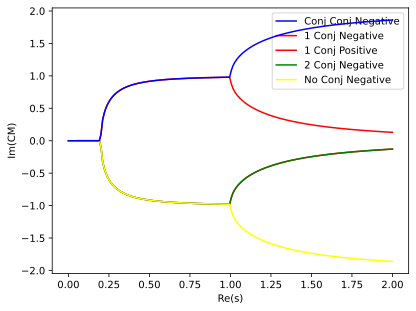

In [54]:
import matplotlib.pyplot as plt

# Assuming x is defined before this point

plt.plot(x, cm_ch12_conj_conj_n[0].imag, c='blue', zorder=99, label='Conj Conj Negative')
#plt.plot(x, cm_ch12_conj_conj_p[0].real, c='blue', zorder=99)

plt.plot(x, cm_ch12_1conj_n[0].imag, c='red', label='1 Conj Negative')
plt.plot(x, cm_ch12_1conj_p[0].imag, c='red', label='1 Conj Positive')

plt.plot(x, cm_ch12_2conj_n[0].imag, c='green', label='2 Conj Negative')
#plt.plot(x, cm_ch12_2conj_p[0].real, c='green')

plt.plot(x, cm_ch12_n[0].imag, c='yellow', label='No Conj Negative')
#plt.plot(x, cm_ch12_p[0].real, c='yellow')

plt.xlabel('Re(s)')
plt.ylabel('Im(CM)')

plt.legend()

plt.show()

In [43]:
def sty(sheet_name: str) -> dict:
    sheet_color = sheet_colors[sheet_name]
    n_lines = 16
    return dict(
        cmin=-vmax,
        cmax=+vmax,
        colorscale=[[0, "rgb(0, 0, 0)"], [1, sheet_color]],
        contours=dict(
            x=dict(
                show=True,
                start=x.min(),
                end=x.max(),
                size=(x.max() - x.min()) / n_lines,
                color="black",
            ),
            y=dict(
                show=True,
                start=-y.max(),
                end=+y.max(),
                size=(y.max() - y.min()) / (n_lines // 2),
                color="black",
            ),
        ),
        name=sheet_name,
        opacity=0.6,
        showscale=False,
    )


vmax = 1.6
project = np.real
projection_text = "Imaginary"
sheet_colors = {
    "Unphysical Channel 12": "green",
    "Unphysical Channel 12 1conj": "red",
    "Physical Channel 12": "blue",
    "Unphysical Channel 12 2conj": "yellow",
}

In [24]:
CMn_ch12 = go.Surface(x=X, y=Yn, z=project(cm_ch12_n), **sty("Physical Channel 12"))
CMp_ch12 = go.Surface(x=X, y=Yp, z=project(cm_ch12_p), **sty("Physical Channel 12"))

CMn_ch12_conj_conj = go.Surface(x=X, y=Yn, z=project(cm_ch12_conj_conj_n), **sty("Unphysical Channel 12"))
CMp_ch12_conj_conj = go.Surface(x=X, y=Yp, z=project(cm_ch12_conj_conj_p), **sty("Unphysical Channel 12"))

CMn_ch12_1conj = go.Surface(x=X, y=Yn, z=project(cm_ch12_1conj_n), **sty("Unphysical Channel 12 1conj"))
CMp_ch12_1conj = go.Surface(x=X, y=Yp, z=project(cm_ch12_1conj_p), **sty("Unphysical Channel 12 1conj"))

CMn_ch12_2conj = go.Surface(x=X, y=Yn, z=project(cm_ch12_2conj_n), **sty("Unphysical Channel 12 2conj"))
CMp_ch12_2conj = go.Surface(x=X, y=Yp, z=project(cm_ch12_2conj_p), **sty("Unphysical Channel 12 2conj"))

fig_cm = make_subplots(
    rows=1,
    cols=3,
    specs=[[{"type": "surface"}, {"type": "surface"}, {"type": "scatter3d"}]],subplot_titles=["Cm Physical", "Cm", "Cm 22"]
)



#point_trace = go.Scatter(x=[m1_plus_m2], y=[0], mode='markers', marker=dict(color='red', size=10), name='m1 + m2')

# Add the point trace to the subplot
#fig_cm.add_trace(point_trace, row=1, col=2)

fig_cm.add_trace(CMn_ch12_conj_conj, row=1, col=1)
fig_cm.add_trace(CMp_ch12, row=1, col=1)

fig_cm.add_trace(CMp_ch12_conj_conj, row=1, col=2)
fig_cm.add_trace(CMn_ch12_conj_conj, row=1, col=2)
fig_cm.add_trace(CMp_ch12_1conj, row=1, col=2)
fig_cm.add_trace(CMp_ch12_2conj, row=1, col=2)
fig_cm.add_trace(CMp_ch12, row=1, col=2)

fig_cm.add_trace(CMn_ch2, row=1, col=3)
fig_cm.add_trace(CMp_ch2_conj, row=1, col=3)


fig_cm.update_layout(
    height=550,
    width=1200,
    showlegend=False,
    title_text=f"Riemann sheets for Chew Mandelstamm ",
)


fig_cm.update_scenes(
    xaxis_title_text="Re s",
    yaxis_title_text="Im s",
    zaxis_range=[-vmax, +vmax],
)

fig_cm.show()

NameError: name 'make_subplots' is not defined

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

CMn_ch1 = go.Surface(x=X, y=Yn, z=project(cm_ch1_n), **sty("Unphysical Channel 1"))
CMp_ch1 = go.Surface(x=X, y=Yp, z=project(cm_ch1_p), **sty("Unphysical Channel 1"))

CMn_ch2 = go.Surface(x=X, y=Yn, z=project(cm_ch2_n), **sty("Unphysical Channel 2"))
CMp_ch2 = go.Surface(x=X, y=Yp, z=project(cm_ch2_p), **sty("Unphysical Channel 2"))

CMn_ch1_conj = go.Surface(x=X, y=Yn, z=project(cm_ch1_conj_n), **sty("Physical Channel 1"))
CMp_ch1_conj = go.Surface(x=X, y=Yp, z=project(cm_ch1_conj_p), **sty("Physical Channel 1"))

CMn_ch2_conj = go.Surface(x=X, y=Yn, z=project(cm_ch2_conj_n), **sty("Physical Channel 2"))
CMp_ch2_conj = go.Surface(x=X, y=Yp, z=project(cm_ch2_conj_p), **sty("Physical Channel 2"))

fig_cm = make_subplots(
    rows=1,
    cols=3,
    specs=[[{"type": "surface"}, {"type": "surface"}, {"type": "scatter3d"}]],subplot_titles=["Channel 1", "Channel 1 and Channel 2", "Channel 2"]
)



#point_trace = go.Scatter(x=[m1_plus_m2], y=[0], mode='markers', marker=dict(color='red', size=10), name='m1 + m2')

# Add the point trace to the subplot
#fig_cm.add_trace(point_trace, row=1, col=2)

fig_cm.add_trace(CMp_ch1_conj, row=1, col=1)
fig_cm.add_trace(CMn_ch1, row=1, col=1)

fig_cm.add_trace(CMp_ch1_conj, row=1, col=2)
fig_cm.add_trace(CMn_ch1_conj, row=1, col=2)
fig_cm.add_trace(CMp_ch1, row=1, col=2)
fig_cm.add_trace(CMn_ch2_conj, row=1, col=2)
fig_cm.add_trace(CMp_ch2_conj, row=1, col=2)

fig_cm.add_trace(CMn_ch2, row=1, col=3)
fig_cm.add_trace(CMp_ch2_conj, row=1, col=3)


fig_cm.update_layout(
    height=550,
    width=1200,
    showlegend=False,
    title_text=f"Riemann sheets for Chew Mandelstamm ",
)


fig_cm.update_scenes(
    xaxis_title_text="Re s",
    yaxis_title_text="Im s",
    zaxis_range=[-vmax, +vmax],
)

fig_cm.show()

## Riemann sheet visualization

In [ ]:
args = (s, m_a_1, m_b_1, m_a_2, m_b_2, m_R, w_R, gamma_R_1, gamma_R_2)
T_cm_func_00 = sp.lambdify(args, T_cm_expr_00.doit())
T_cm_conj_func_00 = sp.lambdify(args, T_cm_conj_expr_00.doit())
T_cm_func_11 = sp.lambdify(args, T_cm_expr_11.doit())
T_cm_conj_func_11 = sp.lambdify(args, T_cm_conj_expr_11.doit())

In [ ]:
ma_1_val = 0.4
mb_1_val = 0.5
mR_val = 4.1
wR_val = 1.0
gamma_1_val = 0.5
ma_2_val = 0.9
mb_2_val = 0.8
gamma_2_val = 1
arg_vals = (
    ma_1_val,
    mb_1_val,
    ma_2_val,
    mb_2_val,
    mR_val,
    wR_val,
    gamma_1_val,
    gamma_2_val,
)


Tp_cm_00 = T_cm_func_00(Zp**2, *arg_vals)
Tn_cm_00 = T_cm_func_00(Zn**2, *arg_vals)

Tp_cm_conj_00 = T_cm_conj_func_00(Zp**2, *arg_vals)
Tn_cm_conj_00 = T_cm_conj_func_00(Zn**2, *arg_vals)

Tp_cm_11 = T_cm_func_11(Zp**2, *arg_vals)
Tn_cm_11 = T_cm_func_11(Zn**2, *arg_vals)

Tp_cm_conj_11 = T_cm_conj_func_11(Zp**2, *arg_vals)
Tn_cm_conj_11 = T_cm_conj_func_11(Zn**2, *arg_vals)

In [ ]:
fig, axes = plt.subplots(figsize=(15, 6), ncols=2, sharey=True)
ax1, ax2 = axes

ax1.plot(x, Tp_cm_00[0].imag)
ax1.plot(x, Tn_cm_conj_00[0].imag)
ax1.set_xlabel("Re(s)")
ax1.set_ylabel("Function Value")
ax1.set_title("T Matrix element 00 with Chew Mandelstamm Function")

ax2.plot(x, Tp_cm_11[0].imag)
ax2.plot(x, Tn_cm_conj_11[0].imag)
ax2.set_xlabel("Re(s)")
ax2.set_ylabel("Function Value")
ax2.set_title("T matrix element 11 with Chew Mandelstamm Function")
plt.tight_layout()
plt.show()

In [ ]:
def sty(sheet_name: str) -> dict:
    sheet_color = sheet_colors[sheet_name]
    n_lines = 16
    return dict(
        cmin=-vmax,
        cmax=+vmax,
        colorscale=[[0, "rgb(0, 0, 0)"], [1, sheet_color]],
        contours=dict(
            x=dict(
                show=True,
                start=x.min(),
                end=x.max(),
                size=(x.max() - x.min()) / n_lines,
                color="black",
            ),
            y=dict(
                show=True,
                start=-y.max(),
                end=+y.max(),
                size=(y.max() - y.min()) / (n_lines // 2),
                color="black",
            ),
        ),
        name=sheet_name,
        opacity=0.6,
        showscale=False,
    )


vmax = 1.6
project = np.imag
projection_text = "Imaginary"
sheet_colors = {
    "Unphysical 00": "blue",
    "Physical 01": "red",
    "Unphysical 10": "green",
    "Physical 11": "yellow",
}

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Sn_cm_00 = go.Surface(x=X, y=Yn, z=project(Tn_cm_00), **sty("Unphysical 00"))
Sp_cm_00 = go.Surface(x=X, y=Yp, z=project(Tp_cm_00), **sty("Unphysical 00"))

Sn_cm_conj_00 = go.Surface(x=X, y=Yn, z=project(Tn_cm_conj_00), **sty("Physical 01"))
Sp_cm_conj_00 = go.Surface(x=X, y=Yp, z=project(Tp_cm_conj_00), **sty("Physical 01"))

intersection_points = []
for i in range(len(x)):
    intersection_points.append((x[i], 0, project(Tn_cm_00[0])[i]))

intersection_points = np.array(intersection_points)
intersection_line = go.Scatter3d(
    x=intersection_points[:, 0],
    y=intersection_points[:, 1],
    z=intersection_points[:, 2],
    mode="lines+markers",
    line=dict(color="yellow", width=20),
    marker=dict(size=1, color="pink"),
    name="Intersection Line",
)

fig0 = make_subplots(
    rows=1,
    cols=3,
    specs=[[{"type": "surface"}, {"type": "surface"}, {"type": "scatter3d"}]],
)

fig0.add_trace(Sn_cm_00, row=1, col=1)
fig0.add_trace(Sp_cm_00, row=1, col=1)

fig0.add_trace(Sn_cm_conj_00, row=1, col=3)
fig0.add_trace(Sp_cm_conj_00, row=1, col=3)

fig0.add_trace(Sn_cm_00, row=1, col=2)
fig0.add_trace(Sp_cm_conj_00, row=1, col=2)


fig0.add_trace(intersection_line, row=1, col=2)

fig0.update_layout(
    height=550,
    width=1200,
    showlegend=False,
    title_text=f"{projection_text} part of T matrix element 00 with Chew-Mandelstam",
)
fig0.update_scenes(
    xaxis_title_text="Re s",
    yaxis_title_text="Im s",
    zaxis_range=[-vmax, +vmax],
)

############################################################################################################

Sn_cm_11 = go.Surface(x=X, y=Yn, z=project(Tn_cm_11), **sty("Unphysical 10"))
Sp_cm_11 = go.Surface(x=X, y=Yp, z=project(Tp_cm_11), **sty("Unphysical 10"))

Sn_cm_conj_11 = go.Surface(x=X, y=Yn, z=project(Tn_cm_conj_11), **sty("Physical 11"))
Sp_cm_conj_11 = go.Surface(x=X, y=Yp, z=project(Tp_cm_conj_11), **sty("Physical 11"))

intersection_points = []
for i in range(len(x)):
    intersection_points.append((x[i], 0, project(Tn_cm_11[0])[i]))

intersection_points = np.array(intersection_points)
intersection_line = go.Scatter3d(
    x=intersection_points[:, 0],
    y=intersection_points[:, 1],
    z=intersection_points[:, 2],
    mode="lines+markers",
    line=dict(color="yellow", width=20),
    marker=dict(size=1, color="pink"),
    name="Intersection Line",
)

fig1 = make_subplots(
    rows=1,
    cols=3,
    specs=[[{"type": "surface"}, {"type": "surface"}, {"type": "scatter3d"}]],
)

fig1.add_trace(Sn_cm_11, row=1, col=1)
fig1.add_trace(Sp_cm_11, row=1, col=1)

fig1.add_trace(Sn_cm_conj_11, row=1, col=3)
fig1.add_trace(Sp_cm_conj_11, row=1, col=3)

fig1.add_trace(Sn_cm_11, row=1, col=2)
fig1.add_trace(Sp_cm_conj_11, row=1, col=2)


fig1.add_trace(intersection_line, row=1, col=2)

fig1.update_layout(
    height=550,
    width=1200,
    showlegend=False,
    title_text=f"{projection_text} part of T matrix element 11 with Chew-Mandelstam",
)
fig1.update_scenes(
    xaxis_title_text="Re s",
    yaxis_title_text="Im s",
    zaxis_range=[-vmax, +vmax],
)
fig0.show()
fig1.show()